In [34]:
# Robust Scaler
results

,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,method
0,0.009885,0.011475,0.708108,0.451445,0.346530,0.655026,0.754457,LogisticRegression
0,0.365011,0.048144,0.763514,0.360354,0.363662,0.360582,0.676917,RandomForest
0,0.006086,0.025764,0.682432,0.392333,0.302186,0.559524,0.689116,KNN
0,0.033759,0.011969,0.708108,0.448571,0.345137,0.647619,0.751725,SVM


In [34]:
# MinMax Scaler
results

,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,method
0,0.010375,0.011985,0.682432,0.420331,0.316821,0.632804,0.724329,LogisticRegression
0,0.422241,0.055509,0.760811,0.329562,0.339078,0.324074,0.675335,RandomForest
0,0.007063,0.029623,0.679730,0.381352,0.295797,0.537566,0.679260,KNN
0,0.027981,0.012795,0.690541,0.416149,0.318869,0.603704,0.723300,SVM


In [35]:
# Standard Scaler
results

,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,method
0,0.009228,0.012362,0.714865,0.458686,0.355263,0.655026,0.754799,LogisticRegression
0,0.440584,0.052608,0.762162,0.328049,0.349593,0.316138,0.673244,RandomForest
0,0.005332,0.025793,0.690541,0.398521,0.309615,0.559788,0.689476,KNN
0,0.042841,0.012599,0.714865,0.459003,0.356169,0.654762,0.753868,SVM


In [1]:
import pandas as pd
import seaborn as sns

# Read data

In [2]:
# Read QuickVina02 results
qvina         = pd.read_csv('qvina.csv')
qvina.columns = ['CID','pose','qvina']

# Read QVina rescored with RF-Score
rfscore_qvina         = pd.read_csv('rfscore_qvina.csv')
rfscore_qvina.columns = ['CID','pose','rfscore_qvina']

In [3]:
top_qvina  = pd.merge(qvina.query('pose == 1'), rfscore_qvina.query('pose == 1'))
top_qvina.drop('pose', axis=1, inplace=True)
top_qvina.head()

,CID,qvina,rfscore_qvina
0,MAR-UNI-c84db004-13,-9.0,6.586498
1,BAR-COM-4e090d3a-53,-7.5,7.221692
2,TRY-UNI-714a760b-6,-6.4,6.377253
3,EDJ-MED-c9f55a56-1,-6.2,5.491030
4,LON-WEI-0a73fcb8-7,-7.4,6.677942


In [4]:
# Read PLANTS results
plants         = pd.read_csv('plants.csv')
plants.columns = ['CID','pose','plants']

# Read PLANTS rescored with RF-Score
rfscore_plants         = pd.read_csv('rfscore_plants.csv', header=None)
rfscore_plants.columns = ['rfscore_plants','CID']
rfscore_plants         = rfscore_plants[['CID','rfscore_plants']]
rfscore_plants[['CID','pose']] = rfscore_plants['CID'].str.split('_', expand=True)
rfscore_plants['pose']         = rfscore_plants['pose'].astype('int')

In [5]:
top_plants = pd.merge(plants.query('pose == 1'), rfscore_plants.query('pose == 1'))
top_plants.drop('pose', axis=1, inplace=True)
top_plants.head()

,CID,plants,rfscore_plants
0,EDG-MED-0da5ad92-3,-70.8540,6.885798
1,DAR-DIA-23aa0b97-19,-79.4982,6.852397
2,MAT-POS-590ac91e-22,-70.4662,6.217164
3,LON-WEI-1908424e-3,-90.5268,7.534084
4,GIA-UNK-30c7cb75-1,-76.6202,6.839672


In [6]:
# Read experimental data
exp = pd.read_csv('activity_data.csv')
exp.head()

,SMILES,CID,canonical_CID,r_inhibition_at_20_uM,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_20_uM,f_inhibition_at_50_uM,f_avg_IC50,f_avg_pIC50,relative_solubility_at_20_uM,relative_solubility_at_100_uM,trypsin_IC50,NMR_std_ratio,acrylamide,chloroacetamide,series
0,COC(=O)C(C(=O)Nc1cnccc1C)c1cccc(Cl)c1,MAT-POS-1e5f28a7-1,MAT-POS-1e5f28a7-1,NaN,NaN,17.091397,NaN,NaN,23.712295,4.625026,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like
1,OCCn1c(CSc2nc3ccccc3o2)nc2ccc(Cl)cc21,MAT-POS-e10a589d-1,MAT-POS-e10a589d-1,NaN,NaN,99.000000,NaN,NaN,0.326703,6.485847,NaN,NaN,NaN,NaN,False,False,NaN
2,N#Cc1ncn(CC(=O)Nc2ccc(Br)cc2Cl)n1,MAT-POS-e10a589d-4,MAT-POS-e10a589d-4,NaN,NaN,NaN,NaN,NaN,15.730897,4.803247,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like
3,Cn1nc(-c2ccc(C(F)(F)F)cc2)nc2c(=O)n(C)c(=O)nc1-2,MAT-POS-1e0c1c67-1,MAT-POS-1e0c1c67-1,NaN,NaN,99.000000,NaN,NaN,2.400602,5.619680,NaN,NaN,NaN,NaN,False,False,NaN
4,Cc1cc2c(cc1C)C(C(=O)N1CCCCC1c1cn[nH]c1)CO2,MAT-POS-6da3605a-1,MAT-POS-6da3605a-1,NaN,NaN,99.000000,NaN,NaN,99.500000,NaN,NaN,NaN,NaN,NaN,False,False,NaN


In [7]:
exp = exp[['CID','r_inhibition_at_50_uM','r_avg_IC50','f_inhibition_at_50_uM','f_avg_IC50']]

In [8]:
tmp = pd.merge(top_qvina, top_plants)
top = pd.merge(tmp, exp)

In [9]:
top

,CID,qvina,rfscore_qvina,plants,rfscore_plants,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_50_uM,f_avg_IC50
0,MAR-UNI-c84db004-13,-9.0,6.586498,-85.9230,7.447876,0.000000,NaN,NaN,NaN
1,BAR-COM-4e090d3a-53,-7.5,7.221692,-83.8857,7.340981,0.000000,NaN,16.960570,NaN
2,TRY-UNI-714a760b-6,-6.4,6.377253,-68.7197,6.414523,NaN,13.895165,81.756960,24.566619
3,EDJ-MED-c9f55a56-1,-6.2,5.491030,-69.4555,6.042434,4.870901,NaN,0.403773,NaN
4,LON-WEI-0a73fcb8-7,-7.4,6.677942,-73.4504,6.826287,58.930356,66.350807,84.229060,13.671987
...,...,...,...,...,...,...,...,...,...
938,MED-COV-4280ac29-14,-6.5,6.078443,-64.1177,6.060790,0.000000,NaN,5.547850,NaN
939,DAR-DIA-842b4336-13,-5.9,6.208389,-72.0692,6.147168,NaN,NaN,11.500410,NaN
940,MAK-UNK-d4768348-1,-6.1,7.048776,-68.5433,7.249597,NaN,0.484415,73.746190,1.630843
941,CHR-SOS-7098f804-3,-6.9,6.042820,-76.6604,6.431856,5.996569,NaN,-15.617840,NaN


In [10]:
# Normalize scores
top['plants'] /= 10
top[['rfscore_qvina','rfscore_plants']] *= -1

In [11]:
top

,CID,qvina,rfscore_qvina,plants,rfscore_plants,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_50_uM,f_avg_IC50
0,MAR-UNI-c84db004-13,-9.0,-6.586498,-8.59230,-7.447876,0.000000,NaN,NaN,NaN
1,BAR-COM-4e090d3a-53,-7.5,-7.221692,-8.38857,-7.340981,0.000000,NaN,16.960570,NaN
2,TRY-UNI-714a760b-6,-6.4,-6.377253,-6.87197,-6.414523,NaN,13.895165,81.756960,24.566619
3,EDJ-MED-c9f55a56-1,-6.2,-5.491030,-6.94555,-6.042434,4.870901,NaN,0.403773,NaN
4,LON-WEI-0a73fcb8-7,-7.4,-6.677942,-7.34504,-6.826287,58.930356,66.350807,84.229060,13.671987
...,...,...,...,...,...,...,...,...,...
938,MED-COV-4280ac29-14,-6.5,-6.078443,-6.41177,-6.060790,0.000000,NaN,5.547850,NaN
939,DAR-DIA-842b4336-13,-5.9,-6.208389,-7.20692,-6.147168,NaN,NaN,11.500410,NaN
940,MAK-UNK-d4768348-1,-6.1,-7.048776,-6.85433,-7.249597,NaN,0.484415,73.746190,1.630843
941,CHR-SOS-7098f804-3,-6.9,-6.042820,-7.66604,-6.431856,5.996569,NaN,-15.617840,NaN


,r_inhibition_at_50_uM,f_inhibition_at_50_uM
r_inhibition_at_50_uM,1.00000,0.69768
f_inhibition_at_50_uM,0.69768,1.00000


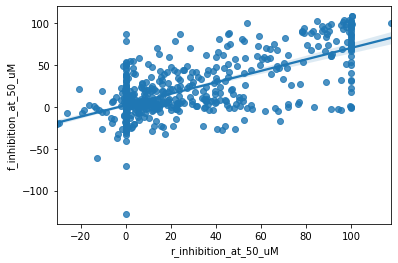

In [12]:
# Correlation between "RapidFire" assay and fluorescence assay
sns.regplot(top['r_inhibition_at_50_uM'], top['f_inhibition_at_50_uM'])
top[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']].corr()

In [13]:
# Read descriptors
descriptors = pd.read_csv('descriptors.csv')
data = pd.merge(top, descriptors)
data.rename({'VABC Volume Descriptor': 'Volume', 'Rotatable Bonds Count': 'Rotatable Bonds', 'Topological Polar Surface Area': 'TPSA'}, axis=1, inplace=True)
data.head()

,CID,qvina,rfscore_qvina,plants,rfscore_plants,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_50_uM,f_avg_IC50,Volume,Rotatable Bonds,TPSA,Molecular Weight,XLogP
0,MAR-UNI-c84db004-13,-9.0,-6.586498,-8.59230,-7.447876,0.000000,NaN,NaN,NaN,424.84863706529114,6,111.52,510.131468,5.100
1,BAR-COM-4e090d3a-53,-7.5,-7.221692,-8.38857,-7.340981,0.000000,NaN,16.960570,NaN,275.6888879402175,6,93.21,312.122240,-0.187
2,TRY-UNI-714a760b-6,-6.4,-6.377253,-6.87197,-6.414523,NaN,13.895165,81.756960,24.566619,231.72693004306151,5,41.99,260.071641,2.401
3,EDJ-MED-c9f55a56-1,-6.2,-5.491030,-6.94555,-6.042434,4.870901,NaN,0.403773,NaN,206.5538721380282,5,70.67,230.116761,1.169
4,LON-WEI-0a73fcb8-7,-7.4,-6.677942,-7.34504,-6.826287,58.930356,66.350807,84.229060,13.671987,271.54289399511737,5,71.45,318.077120,1.647


In [14]:
# Label actives and inactives
data.dropna(subset=['r_inhibition_at_50_uM'], inplace=True)
data['Active'] = data['r_inhibition_at_50_uM'] > 50
data['Active'] = data['Active'].astype(int) # 1 for active, 0 for inactive

In [15]:
# Subset for the ML models
subset = ['qvina','rfscore_qvina','Volume','Rotatable Bonds','TPSA','Molecular Weight','XLogP']
data.dropna(subset=subset, inplace=True)
data['Active'].value_counts()

0    604
1    136
Name: Active, dtype: int64

In [16]:
y = data['Active']
X = data[subset].values

In [17]:
from sklearn.preprocessing import RobustScaler

In [18]:
# Scale data to [0, 1]
X = RobustScaler().fit_transform(X)

## Evaluation metrics

* Accuracy score: true positives / total
* Precision: low false positive rate
* Recall (sensitivity): true positives / all positives
* F1 score: weighted avg of precision and recall ~ better than accuracy for uneven class distribution
* Roc_auc: TPR / FPR

In [19]:
scoring_metrics = ['accuracy','f1','precision','recall','roc_auc']

In [20]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

## Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
lr = make_pipeline(SMOTE(random_state=42), LogisticRegression(solver='liblinear', random_state=13))
results = pd.DataFrame(cross_validate(lr, X, y, scoring=scoring_metrics)).mean().to_frame().T
results['method'] = 'LogisticRegression'

## Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
rfc = make_pipeline(SMOTE(random_state=42), RandomForestClassifier(n_estimators=100, random_state=13))
tmp = pd.DataFrame(cross_validate(rfc, X, y, scoring=scoring_metrics)).mean().to_frame().T
tmp['method'] = 'RandomForest'
results = results.append(tmp)

## KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
knn = make_pipeline(SMOTE(random_state=42), KNeighborsClassifier(n_neighbors=3))
tmp = pd.DataFrame(cross_validate(knn, X, y, scoring=scoring_metrics)).mean().to_frame().T
tmp['method'] = 'KNN'
results = results.append(tmp)

## SVM

In [27]:
from sklearn.svm import SVC

In [28]:
svm = make_pipeline(SMOTE(random_state=42), SVC(kernel='linear', random_state=13))
tmp = pd.DataFrame(cross_validate(svm, X, y, scoring=scoring_metrics)).mean().to_frame().T
tmp['method'] = 'SVM'
results = results.append(tmp)

In [29]:
results

,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,method
0,0.008262,0.008959,0.708108,0.451445,0.346530,0.655026,0.754457,LogisticRegression
0,0.352618,0.048309,0.763514,0.360354,0.363662,0.360582,0.676917,RandomForest
0,0.005599,0.026243,0.682432,0.392333,0.302186,0.559524,0.689116,KNN
0,0.033254,0.011085,0.708108,0.448571,0.345137,0.647619,0.751725,SVM


# Model evaluation

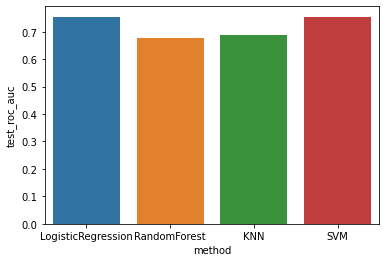

In [34]:
sns.barplot(data=results, x='method', y='test_roc_auc')

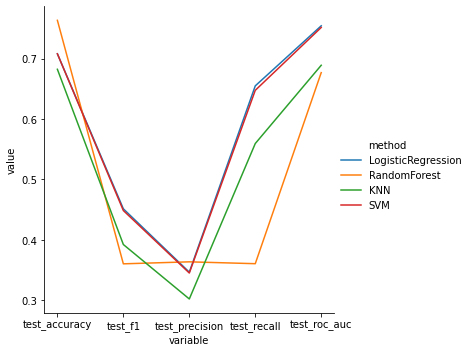

In [30]:
melt = results.melt(id_vars='method', 
                    value_vars=['test_accuracy','test_f1','test_precision','test_recall','test_roc_auc'])
sns.relplot(kind='line', data=melt, x='variable', y='value', hue='method', sort=False)

In [31]:
from sklearn.model_selection import KFold

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve
%matplotlib inline

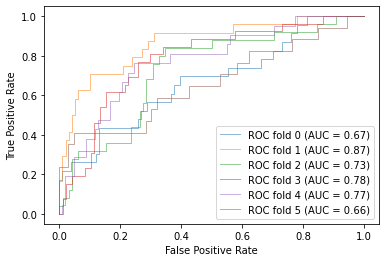

In [33]:
# Run classifier with cross-validation and plot ROC curves
cv = KFold(n_splits=6)
classifier = LogisticRegression(solver='liblinear', random_state=13)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], np.array(y)[train])
    viz = plot_roc_curve(classifier, X[test], np.array(y)[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.5, lw=1, ax=ax)